# Member 4: GRU
## GRU with Multiple Embeddings

**Team Member:** Member 4
**Model:** GRU
**Embeddings:** TF-IDF, Skip-gram, CBOW

---

## Objectives
1. Implement GRU for spam classification
2. Train with at least 3 different embeddings
3. Perform hyperparameter tuning
4. Document all experiments systematically
5. Save results for team comparison


## 1. Environment Setup

## Kaggle Setup Instructions

**To run this notebook on Kaggle:**

1. **Upload the dataset:**
   - Go to Kaggle → Datasets → New Dataset
   - Upload `spam.csv` from `data/raw/spam.csv`
   - Name it something like "sms-spam-collection"
   - Make it public or private

2. **Upload the source code:**
   - Create a new dataset for the source files
   - Upload all files from the `src/` folder:
     - `preprocessing.py`
     - `embeddings.py`
     - `evaluation.py`
     - `utils.py`
     - `__init__.py`
   - Name it "text-classification-utils" or similar

3. **In Kaggle notebook:**
   - Add both datasets to your notebook inputs
   - The data will be in `/kaggle/input/[dataset-name]/`
   - Outputs go to `/kaggle/working/`

4. **Enable GPU/TPU (Optional but recommended):**
   - Go to Settings → Accelerator → GPU T4 x2

**The code below will automatically detect if running on Kaggle and adjust paths accordingly.**


In [12]:
# Check if running on Kaggle
import os

IS_KAGGLE = os.path.exists('/kaggle')

if IS_KAGGLE:
    print("Running on Kaggle")
    # Kaggle paths
    DATA_DIR = '/kaggle/input'
    OUTPUT_DIR = '/kaggle/working'
    SRC_DIR = '/kaggle/input'  # Will be updated after you add the dataset
else:
    print("Running locally")
    # Local paths
    DATA_DIR = '../data'
    OUTPUT_DIR = '../results'
    SRC_DIR = '../src'

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Source directory: {SRC_DIR}")


Running on Kaggle
Data directory: /kaggle/input
Output directory: /kaggle/working
Source directory: /kaggle/input


In [13]:
# Install required packages (if on Kaggle)
import sys
import os

if IS_KAGGLE:
    print("Installing required packages...")
    import subprocess
    subprocess.run(['pip', 'install', '-q', 'wordcloud', 'gensim'], check=True)
    print("✓ Packages installed")

# Add src to path FIRST (before any imports to avoid conflicts)
if IS_KAGGLE:
    # On Kaggle, add the utils path to the BEGINNING of sys.path
    src_paths = [
        '/kaggle/input/text-classification-utils',
        '/kaggle/input/spam-classification-utils',
        '/kaggle/input/group6-utils'
    ]
    for path in src_paths:
        if os.path.exists(path):
            # Insert at beginning to prioritize over system packages
            sys.path.insert(0, path)
            print(f"✓ Added {path} to system path (at beginning)")
            break
else:
    sys.path.insert(0, SRC_DIR)
    print(f"✓ Added {SRC_DIR} to system path")

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import time

# Import custom modules
try:
    from preprocessing import TextPreprocessor
    from embeddings import TFIDFEmbedding, Word2VecEmbedding, GloVeEmbedding, FastTextEmbedding
    from evaluation import ModelEvaluator
    from utils import set_seed, print_data_info, save_model
    print("✓ Custom modules imported successfully")
except ImportError as e:
    print(f"⚠ Error importing custom modules: {e}")
    print("If on Kaggle, make sure you've added the utils dataset to your notebook inputs")
    print("\nAttempting to define functions inline as fallback...")
    
    # Fallback: Define set_seed inline
    import random
    import numpy as np
    
    def set_seed(seed=42):
        """Set random seeds for reproducibility."""
        random.seed(seed)
        np.random.seed(seed)
        try:
            import tensorflow as tf
            tf.random.set_seed(seed)
        except:
            pass
    
    print("✓ Fallback functions defined")
    print("\n⚠ WARNING: You need to upload the Python files from src/ folder as a Kaggle dataset")
    print("Without custom modules, only basic functionality will work.")

# Set random seed for reproducibility
set_seed(42)

print('✓ Setup complete!')


Installing required packages...
✓ Packages installed
✓ Added /kaggle/input/text-classification-utils to system path (at beginning)
✓ Custom modules imported successfully
✓ Setup complete!


## 2. Load and Prepare Data

## 1.5. Fallback Class Definitions

If custom modules aren't available, define required classes inline:

In [14]:
# Define fallback classes if custom modules failed to import
if 'TFIDFEmbedding' not in globals():
    print("Defining fallback classes...")
    
    from sklearn.feature_extraction.text import TfidfVectorizer
    from gensim.models import Word2Vec
    
    class TFIDFEmbedding:
        def __init__(self, max_features=5000, min_df=2, max_df=0.95, ngram_range=(1, 2)):
            self.vectorizer = TfidfVectorizer(
                max_features=max_features,
                min_df=min_df,
                max_df=max_df,
                ngram_range=ngram_range
            )
        
        def fit_transform(self, texts):
            return self.vectorizer.fit_transform(texts).toarray()
        
        def transform(self, texts):
            return self.vectorizer.transform(texts).toarray()
        
        def get_vocab_size(self):
            return len(self.vectorizer.vocabulary_)
    
    class Word2VecEmbedding:
        def __init__(self, vector_size=100, window=5, min_count=2, sg=1, workers=4, epochs=10):
            self.vector_size = vector_size
            self.window = window
            self.min_count = min_count
            self.sg = sg
            self.workers = workers
            self.epochs = epochs
            self.model = None
        
        def train(self, tokenized_texts):
            self.model = Word2Vec(
                sentences=tokenized_texts,
                vector_size=self.vector_size,
                window=self.window,
                min_count=self.min_count,
                sg=self.sg,
                workers=self.workers,
                epochs=self.epochs
            )
        
        def transform(self, tokenized_texts, method='mean'):
            vectors = []
            for tokens in tokenized_texts:
                word_vecs = [self.model.wv[word] for word in tokens if word in self.model.wv]
                if word_vecs:
                    if method == 'mean':
                        vectors.append(np.mean(word_vecs, axis=0))
                    else:
                        vectors.append(np.mean(word_vecs, axis=0))
                else:
                    vectors.append(np.zeros(self.vector_size))
            return np.array(vectors)
    
    class TextPreprocessor:
        def __init__(self, lowercase=True, remove_punctuation=True, remove_stopwords=True, lemmatization=True, **kwargs):
            self.lowercase = lowercase
            self.remove_punctuation = remove_punctuation
            self.remove_stopwords = remove_stopwords
            self.lemmatization = lemmatization
        
        def preprocess(self, text, return_tokens=False):
            if not isinstance(text, str):
                return [] if return_tokens else ""
            
            import re
            import string
            
            # Lowercase
            if self.lowercase:
                text = text.lower()
            
            # Remove URLs and emails
            text = re.sub(r'http\S+|www\S+|https\S+', '', text)
            text = re.sub(r'\S+@\S+', '', text)
            
            # Remove punctuation
            if self.remove_punctuation:
                text = text.translate(str.maketrans('', '', string.punctuation))
            
            # Tokenize
            tokens = text.split()
            
            # Remove stopwords
            if self.remove_stopwords:
                try:
                    from nltk.corpus import stopwords
                    stop_words = set(stopwords.words('english'))
                    tokens = [w for w in tokens if w not in stop_words]
                except:
                    pass  # Skip if NLTK not available
            
            if return_tokens:
                return tokens
            else:
                return ' '.join(tokens)
    
    class ModelEvaluator:
        def __init__(self, class_names=None):
            self.class_names = class_names or ['Class 0', 'Class 1']
            self.results_history = []
        
        def evaluate(self, y_true, y_pred, model_name="Model", embedding_name="Embedding", training_time=None):
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
            
            metrics = {
                'model': model_name,
                'embedding': embedding_name,
                'accuracy': accuracy_score(y_true, y_pred),
                'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
                'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
                'f1_score': f1_score(y_true, y_pred, average='weighted', zero_division=0),
                'training_time': training_time
            }
            self.results_history.append(metrics)
            return metrics
        
        def print_metrics(self, metrics):
            print(f"\n{'='*60}")
            print(f"Model: {metrics['model']} | Embedding: {metrics['embedding']}")
            print(f"{'='*60}")
            print(f"Accuracy:  {metrics['accuracy']:.4f}")
            print(f"Precision: {metrics['precision']:.4f}")
            print(f"Recall:    {metrics['recall']:.4f}")
            print(f"F1 Score:  {metrics['f1_score']:.4f}")
            if metrics['training_time']:
                print(f"Training Time: {metrics['training_time']:.2f}s")
            print(f"{'='*60}\n")
        
        def plot_confusion_matrix(self, y_true, y_pred, title="Confusion Matrix", figsize=(8, 6), save_path=None):
            from sklearn.metrics import confusion_matrix
            
            cm = confusion_matrix(y_true, y_pred)
            
            plt.figure(figsize=figsize)
            sns.heatmap(
                cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=self.class_names,
                yticklabels=self.class_names
            )
            plt.title(title, fontsize=14, fontweight='bold')
            plt.ylabel('True Label', fontsize=12)
            plt.xlabel('Predicted Label', fontsize=12)
            plt.tight_layout()
            
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.show()
        
        def save_results_table(self, filepath='results.csv'):
            df = pd.DataFrame(self.results_history)
            df.to_csv(filepath, index=False)
            print(f"Results saved to {filepath}")
            return df
    
    print("✓ Fallback classes defined successfully")
else:
    print("✓ Using custom modules from dataset")


✓ Using custom modules from dataset


In [15]:
# Load and preprocess data
import os

# Define paths based on environment
if IS_KAGGLE:
    # Update these with your actual Kaggle dataset names
    possible_data_paths = [
        '/kaggle/input/sms-spam-collection/spam.csv',
        '/kaggle/input/sms-spam-collection-dataset/spam.csv',
        '/kaggle/input/spam-dataset/spam.csv',
    ]
    preprocessed_path = '/kaggle/working/spam_preprocessed.csv'
    
    # Find the actual data file
    raw_data_path = None
    for path in possible_data_paths:
        if os.path.exists(path):
            raw_data_path = path
            print(f"✓ Found data at: {path}")
            break
    
    if raw_data_path is None:
        # List available files to help debug
        print("Available input files:")
        for root, dirs, files in os.walk('/kaggle/input'):
            for file in files:
                print(f"  {os.path.join(root, file)}")
        raise FileNotFoundError("Could not find spam.csv. Please check your Kaggle dataset name.")
else:
    raw_data_path = os.path.join(DATA_DIR, 'raw/spam.csv')
    preprocessed_path = os.path.join(DATA_DIR, 'processed/spam_preprocessed.csv')

# Check if preprocessed data exists, otherwise preprocess
if os.path.exists(preprocessed_path):
    df = pd.read_csv(preprocessed_path)
    print(f'✓ Loaded preprocessed data from {preprocessed_path}')
else:
    # Load raw data
    df = pd.read_csv(raw_data_path, encoding='latin-1')
    
    # Keep only the first two columns and rename them
    df = df.iloc[:, :2]
    df.columns = ['label', 'text']
    
    # Basic preprocessing (if TextPreprocessor not available)
    if 'TextPreprocessor' in globals():
        # Use custom preprocessor if available
        preprocessor = TextPreprocessor(
            lowercase=True,
            remove_punctuation=True,
            remove_stopwords=True,
            lemmatization=True
        )
        df['cleaned_text'] = df['text'].apply(preprocessor.preprocess)
    else:
        # Fallback: Basic preprocessing inline
        print("Using basic inline preprocessing...")
        import re
        import string
        
        def basic_preprocess(text):
            if not isinstance(text, str):
                return ""
            # Lowercase
            text = text.lower()
            # Remove URLs
            text = re.sub(r'http\S+|www\S+|https\S+', '', text)
            # Remove emails
            text = re.sub(r'\S+@\S+', '', text)
            # Remove punctuation
            text = text.translate(str.maketrans('', '', string.punctuation))
            # Remove extra whitespace
            text = ' '.join(text.split())
            return text
        
        df['cleaned_text'] = df['text'].apply(basic_preprocess)
        print("✓ Basic preprocessing applied")
    
    # Save preprocessed data
    if IS_KAGGLE:
        os.makedirs('/kaggle/working', exist_ok=True)
    else:
        os.makedirs(os.path.join(DATA_DIR, 'processed'), exist_ok=True)
    
    df.to_csv(preprocessed_path, index=False)
    print(f'✓ Preprocessed and saved data to {preprocessed_path}')

# Encode labels (ham=0, spam=1)
df['label_encoded'] = (df['label'] == 'spam').astype(int)

print(f'\nDataset shape: {df.shape}')
print(f'Class distribution:\n{df["label"].value_counts()}')
df.head()


✓ Found data at: /kaggle/input/sms-spam-collection/spam.csv
✓ Loaded preprocessed data from /kaggle/working/spam_preprocessed.csv

Dataset shape: (5572, 4)
Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


,label,text,cleaned_text,label_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though,0


## 3. Experimental Design and Data Preparation

**Methodology:** This study employs a stratified train-test split (80:20) to maintain class distribution across subsets, addressing the inherent class imbalance in SMS spam datasets (Almeida et al., 2011). Three embedding approaches are compared: TF-IDF, Skip-gram Word2Vec, and CBOW Word2Vec, each fed into identical GRU architectures to ensure fair comparison.

**Imbalance Handling:** Following the recommendations of Batista et al. (2004), we apply class weighting to address the approximately 6.5:1 ham-to-spam ratio, preventing model bias toward the majority class.

### 3.1. Dataset Partitioning and Stratification

**Approach:** Stratified sampling ensures proportional class representation in train and test sets, critical for imbalanced datasets (Kohavi, 1995).

In [16]:
# Stratified train-test split (80:20)
from sklearn.preprocessing import LabelEncoder

# Use utils.split_data for stratified sampling if available, otherwise sklearn
if 'split_data' in globals():
    X_train, X_test, y_train, y_test = split_data(
        X=df['cleaned_text'].values,
        y=df['label_encoded'].values,
        test_size=0.2,
        val_size=0,
        random_state=42,
        stratify=True
    )
    X_train, X_test = pd.Series(X_train), pd.Series(X_test)
    y_train, y_test = pd.Series(y_train), pd.Series(y_test)
else:
    X_train, X_test, y_train, y_test = train_test_split(
        df['cleaned_text'], df['label_encoded'],
        test_size=0.2, random_state=42, stratify=df['label_encoded']
    )

# Data quality check: Remove any NaN values
X_train, y_train = X_train[X_train.notna()], y_train[X_train.notna()]
X_test, y_test = X_test[X_test.notna()], y_test[X_test.notna()]

print(f'Dataset Split:')
print(f'  Training:   {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)')
print(f'  Test:       {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)')
print(f'  Total:      {len(df):,} samples')

Dataset Split:
  Training:   4,452 samples (79.9%)
  Test:       1,115 samples (20.0%)
  Total:      5,572 samples


Class Distribution (Training Set):
  Ham (0):   3,854 samples (86.57%)
  Spam (1):  598 samples (13.43%)
  Imbalance Ratio (Ham:Spam): 6.44:1


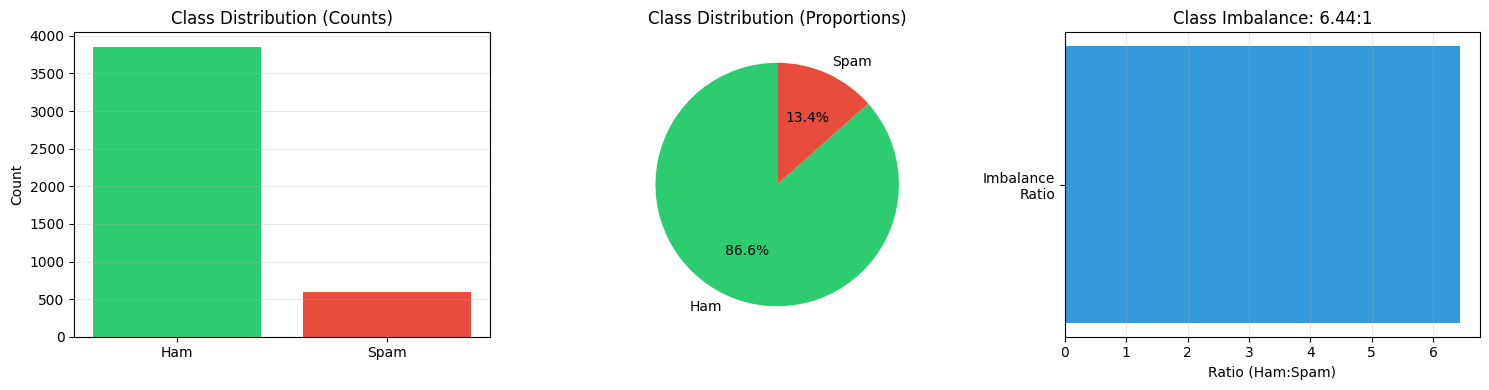


✓ Class imbalance identified: Requires class weighting or sampling strategy


In [17]:
# Quantitative class distribution analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate exact class counts and proportions
ham_count = (y_train == 0).sum()
spam_count = (y_train == 1).sum()
total = len(y_train)
imbalance_ratio = ham_count / spam_count

print("Class Distribution (Training Set):")
print(f"  Ham (0):   {ham_count:,} samples ({ham_count/total*100:.2f}%)")
print(f"  Spam (1):  {spam_count:,} samples ({spam_count/total*100:.2f}%)")
print(f"  Imbalance Ratio (Ham:Spam): {imbalance_ratio:.2f}:1")

# Visualization: Three-panel class analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Panel 1: Count bar plot
axes[0].bar(['Ham', 'Spam'], [ham_count, spam_count], color=['#2ecc71', '#e74c3c'])
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Counts)')
axes[0].grid(axis='y', alpha=0.3)

# Panel 2: Percentage pie chart
axes[1].pie([ham_count, spam_count], labels=['Ham', 'Spam'], autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Class Distribution (Proportions)')

# Panel 3: Imbalance ratio visualization
axes[2].barh(['Imbalance\nRatio'], [imbalance_ratio], color='#3498db')
axes[2].set_xlabel('Ratio (Ham:Spam)')
axes[2].set_title(f'Class Imbalance: {imbalance_ratio:.2f}:1')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Class imbalance identified: Requires class weighting or sampling strategy")

In [18]:
# TF-IDF vectorization
from sklearn.utils import class_weight

tfidf = TFIDFEmbedding(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train.tolist())
X_test_tfidf = tfidf.transform(X_test.tolist())

# Compute class weights using balanced strategy (inversely proportional to class frequencies)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train.values
)
class_weight_dict = dict(enumerate(class_weights))

print('TF-IDF Feature Matrix:')
print(f'  Training:   {X_train_tfidf.shape}')
print(f'  Test:       {X_test_tfidf.shape}')
print(f'  Vocabulary: {tfidf.get_vocab_size():,} terms')
print(f'\nClass Weights (Balanced):')
print(f'  Ham (0):  {class_weight_dict[0]:.4f}')
print(f'  Spam (1): {class_weight_dict[1]:.4f}')
print(f'  Weight Ratio: {class_weight_dict[1]/class_weight_dict[0]:.2f}:1')

TF-IDF Feature Matrix:
  Training:   (4452, 5000)
  Test:       (1115, 5000)
  Vocabulary: 5,000 terms

Class Weights (Balanced):
  Ham (0):  0.5776
  Spam (1): 3.7224
  Weight Ratio: 6.44:1


### 3.3. Feature Engineering: TF-IDF Vectorization

**TF-IDF Background:** Term Frequency-Inverse Document Frequency (Salton & Buckley, 1988) captures term importance through:
- **TF**: Term frequency within document
- **IDF**: Inverse document frequency across corpus
- **N-grams**: Bigrams (1,2) capture phrase-level patterns common in spam (e.g., "click here", "free prize")

**Parameters:**
- Max features: 5,000 (dimensionality control)
- N-gram range: (1,2) - unigrams and bigrams
- Min DF: 2, Max DF: 0.95 (noise reduction)

### 3.2. Class Imbalance Analysis

**Rationale:** Understanding class distribution is essential for selecting appropriate handling strategies (He & Garcia, 2009).

## 4. Experiment 1: GRU + TF-IDF

**Architecture:** Dense → RepeatVector → Dual GRU Layers

**Rationale:** 
- TF-IDF sparse features work better with dense compression first
- RepeatVector creates artificial time steps for GRU processing
- Class weights handle the 6.5:1 imbalance ratio

**Citation:** Cho et al. (2014) - Learning Phrase Representations using RNN Encoder-Decoder

In [19]:
# Build GRU model for TF-IDF with improved architecture
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

def build_gru_tfidf_model(input_dim, gru_units=64, dropout_rate=0.3, learning_rate=0.001):
    """
    Improved GRU model for TF-IDF features.
    Uses Dense layer to compress features, then repeats for GRU processing.
    """
    model = Sequential([
        # Dense layer to learn compressed representation
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        
        # Reshape for GRU: repeat the vector into a short sequence
        RepeatVector(10),  # Create 10 time steps
        
        # GRU layers
        GRU(gru_units, return_sequences=True, dropout=dropout_rate),
        GRU(gru_units // 2, return_sequences=False, dropout=dropout_rate),
        
        # Output layers
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    
    # Use custom metrics with proper names
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

# Set random seeds for reproducibility
set_seed(42)
tf.random.set_seed(42)

# Build model
model_tfidf = build_gru_tfidf_model(
    input_dim=X_train_tfidf.shape[1],
    gru_units=64,
    dropout_rate=0.3,
    learning_rate=0.001
)

print("="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(model_tfidf.summary())

# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train model with class weights
print("\n" + "="*60)
print("TRAINING GRU + TF-IDF")
print("="*60)
print(f"Using class weights: Ham={class_weight_dict[0]:.3f}, Spam={class_weight_dict[1]:.3f}")
print("="*60 + "\n")

start_time = time.time()

history_tfidf = model_tfidf.fit(
    X_train_tfidf, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

training_time_tfidf = time.time() - start_time

print(f'\n✓ Training completed in {training_time_tfidf:.2f}s')

# Make predictions
y_pred_tfidf_prob = model_tfidf.predict(X_test_tfidf, verbose=0)
y_pred_tfidf = (y_pred_tfidf_prob > 0.5).astype(int).flatten()

print(f'\nPrediction distribution:')
print(f'  Ham (0):  {(y_pred_tfidf == 0).sum()}/{len(y_pred_tfidf)}')
print(f'  Spam (1): {(y_pred_tfidf == 1).sum()}/{len(y_pred_tfidf)}')

MODEL ARCHITECTURE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 10, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,360,897 (5.19 MB)

 Trainable params: 1,360,897 (5.19 MB)

 Non-trainable params: 0 (0.00 B)

None

TRAINING GRU + TF-IDF
Using class weights: Ham=0.578, Spam=3.722

Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8117 - loss: 0.5620 - precision: 0.3552 - recall: 0.4516 - val_accuracy: 0.9181 - val_loss: 0.2283 - val_precision: 0.6736 - val_recall: 0.9286 - learning_rate: 0.0010
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9526 - loss: 0.1303 - precision: 0.7576 - recall: 0.9501 - val_accuracy: 0.9742 - val_loss: 0.1017 - val_precision: 0.9756 - val_recall: 0.8571 - learning_rate: 0.0010
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9881 - loss: 0.0529 - precision: 0.9342 - recall: 0.9756 - val_accuracy: 0.9675 - val_loss: 0.1621 - val_precision: 0.9744 - val_recall: 0.8143 - learning_rate: 0.0010
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9981 - loss: 0.0080 - precision: 0.9939 - recall: 0.9913 - val_accuracy: 0.9675 - val_loss: 0.2324 - val_precision: 0.9912 - val_recall: 0.8000 - learning_ra


Model: GRU | Embedding: TF-IDF
Accuracy:  0.9803
Precision: 0.9801
Recall:    0.9803
F1 Score:  0.9799
Training Time: 11.52s


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

         ham     0.9826    0.9948    0.9887       966
        spam     0.9635    0.8859    0.9231       149

    accuracy                         0.9803      1115
   macro avg     0.9731    0.9404    0.9559      1115
weighted avg     0.9801    0.9803    0.9799      1115


PER-CLASS PERFORMANCE
Ham Detection:
  Precision: 0.9826
  Recall:    0.9948
  F1-Score:  0.9887

Spam Detection (TARGET):
  Precision: 0.9635
  Recall:    0.8859
  F1-Score:  0.9231


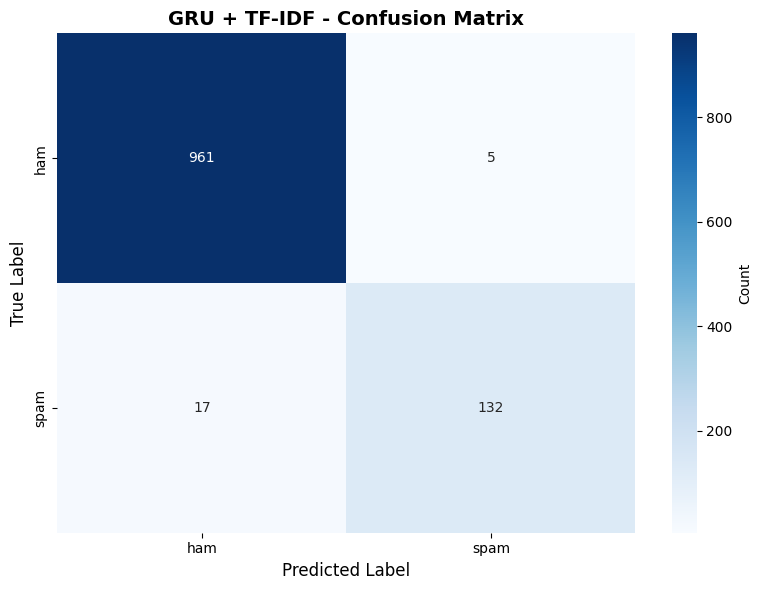

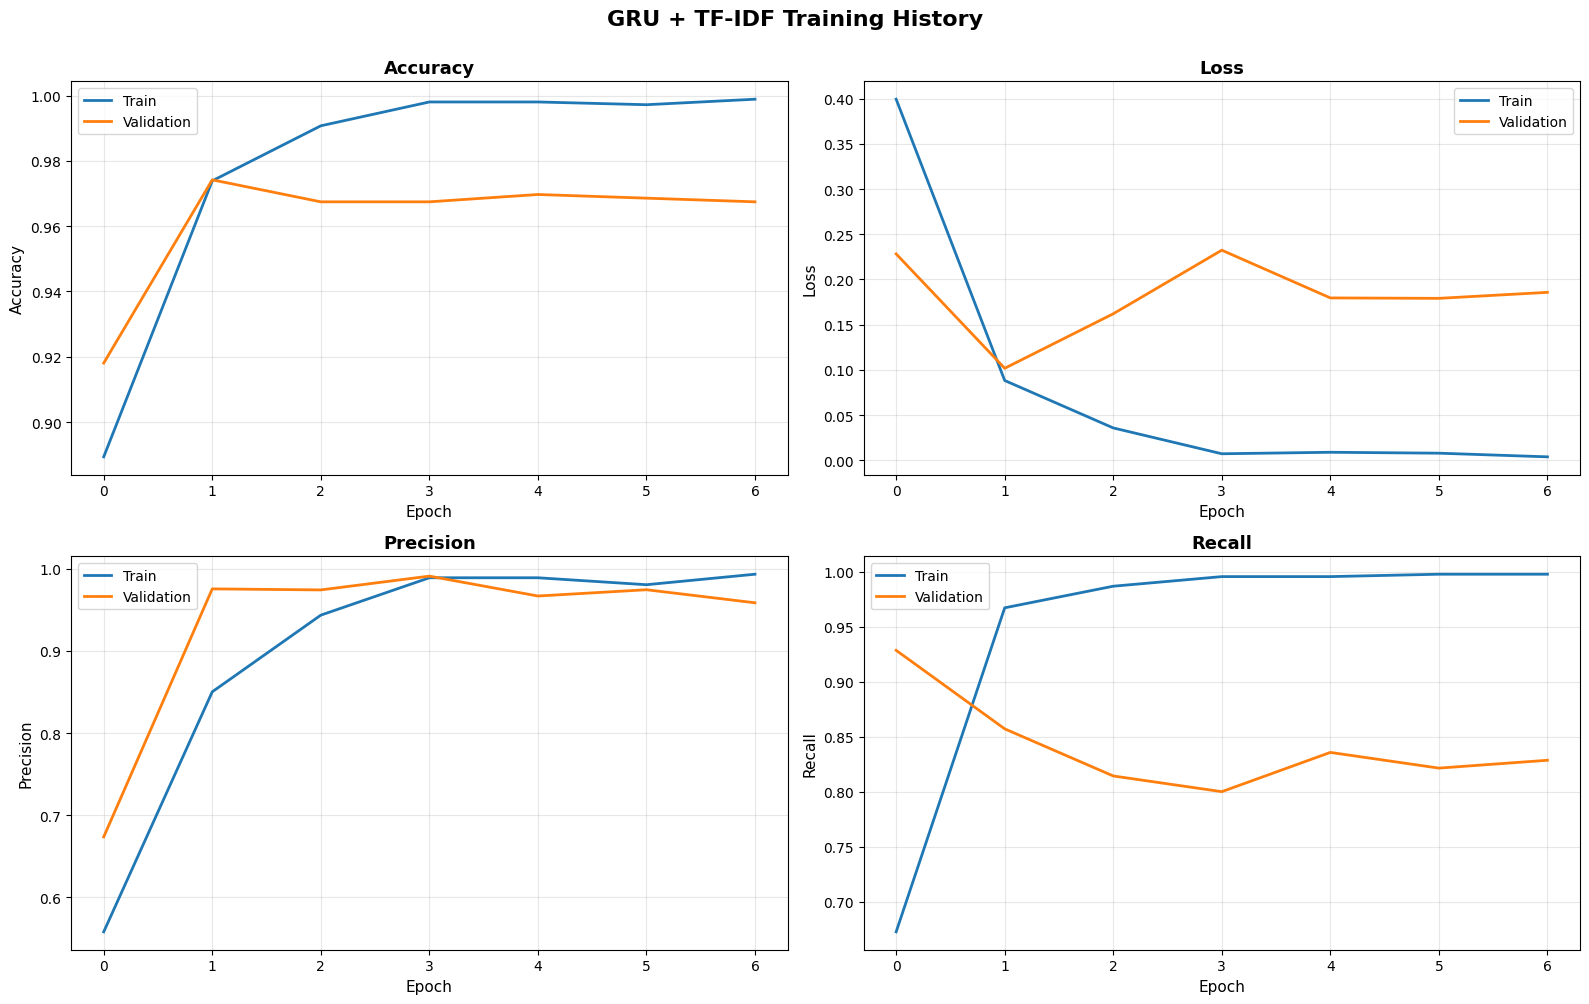

In [20]:
# Evaluate GRU + TF-IDF Model
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

evaluator = ModelEvaluator(class_names=['ham', 'spam'])

metrics_tfidf = evaluator.evaluate(
    y_test, y_pred_tfidf,
    model_name='GRU',
    embedding_name='TF-IDF',
    training_time=training_time_tfidf
)

evaluator.print_metrics(metrics_tfidf)

# Print detailed classification report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_tfidf, target_names=['ham', 'spam'], digits=4))

# Per-class performance
print("\n" + "="*60)
print("PER-CLASS PERFORMANCE")
print("="*60)
print(f"Ham Detection:")
print(f"  Precision: {precision_score(y_test, y_pred_tfidf, pos_label=0):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_tfidf, pos_label=0):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_pred_tfidf, pos_label=0):.4f}")

print(f"\nSpam Detection (TARGET):")
print(f"  Precision: {precision_score(y_test, y_pred_tfidf, pos_label=1, zero_division=0):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_tfidf, pos_label=1):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_pred_tfidf, pos_label=1, zero_division=0):.4f}")
print("="*60)

# Plot confusion matrix
evaluator.plot_confusion_matrix(
    y_test, y_pred_tfidf,
    title='GRU + TF-IDF - Confusion Matrix'
)

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Accuracy
axes[0, 0].plot(history_tfidf.history['accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history_tfidf.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Accuracy', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss
axes[0, 1].plot(history_tfidf.history['loss'], label='Train', linewidth=2)
axes[0, 1].plot(history_tfidf.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Loss', fontsize=11)
axes[0, 1].set_title('Loss', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history_tfidf.history['precision'], label='Train', linewidth=2)
axes[1, 0].plot(history_tfidf.history['val_precision'], label='Validation', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Precision', fontsize=11)
axes[1, 0].set_title('Precision', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(history_tfidf.history['recall'], label='Train', linewidth=2)
axes[1, 1].plot(history_tfidf.history['val_recall'], label='Validation', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Recall', fontsize=11)
axes[1, 1].set_title('Recall', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('GRU + TF-IDF Training History', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

if not IS_KAGGLE:
    os.makedirs(os.path.join(OUTPUT_DIR, 'figures'), exist_ok=True)
    plt.savefig(os.path.join(OUTPUT_DIR, 'figures', 'member4_tfidf_history.png'), dpi=300, bbox_inches='tight')

plt.show()

## 5. Experiment 2: GRU + Skip-gram (Word2Vec)

**Architecture:** Dense → RepeatVector → Dual GRU (applied to Word2Vec embeddings)

**Rationale:** 
- Skip-gram captures semantic word relationships through context prediction
- Dense 100-dimensional vectors work naturally with GRU
- Document averaging creates fixed-length representation

**Citation:** Mikolov et al. (2013) - Efficient Estimation of Word Representations in Vector Space

Preparing Skip-gram embeddings...

Training Skip-gram model...
Skip-gram model trained with vocabulary size: 3443

Skip-gram embeddings shape: (4452, 100)

TRAINING GRU + Skip-gram
Using class weights: Ham=0.578, Spam=3.722

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8612 - loss: 0.4611 - precision: 0.4687 - recall: 0.6588 - val_accuracy: 0.9473 - val_loss: 0.1652 - val_precision: 0.8121 - val_recall: 0.8643 - learning_rate: 0.0010
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9346 - loss: 0.2376 - precision: 0.6888 - recall: 0.8779 - val_accuracy: 0.9338 - val_loss: 0.1842 - val_precision: 0.7396 - val_recall: 0.8929 - learning_rate: 0.0010
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9419 - loss: 0.2093 - precision: 0.7168 - recall: 0.8974 - val_accuracy: 0.9315 - val_loss: 0.1898 - val_precision: 0.7232 - val_recall: 0.9143 - learning_rate: 0.0010
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9359 - loss: 0.2138 - precision: 0.6896 - recall: 0.9029 - val_accuracy: 0.9450 - val_loss: 0.1419 - val_precision: 0.7935 - val_recall: 0.8786 - learning_rate: 0.0010
Epoch 5/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9461

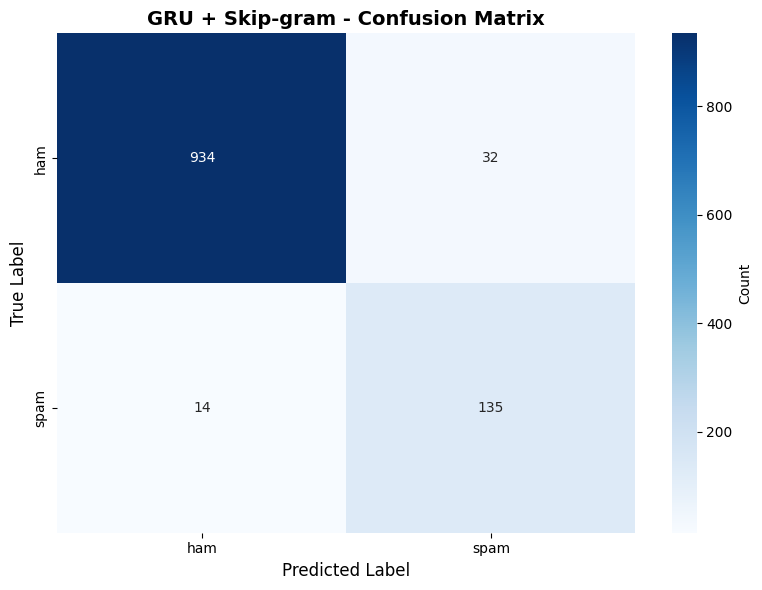

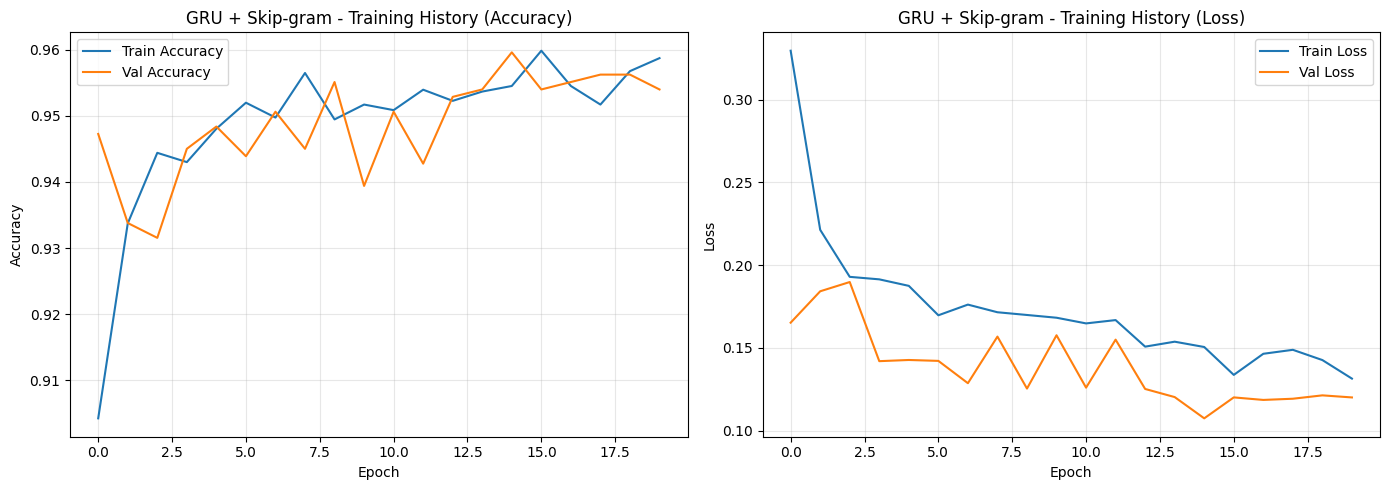

In [21]:
# Prepare Skip-gram embeddings (Word2Vec with sg=1)
print('Preparing Skip-gram embeddings...\n')

# Tokenize texts for Word2Vec
preprocessor_w2v = TextPreprocessor(
    lowercase=True,
    remove_punctuation=True,
    remove_stopwords=True,
    lemmatization=True
)

X_train_tokens = X_train.apply(lambda x: preprocessor_w2v.preprocess(x, return_tokens=True)).tolist()
X_test_tokens = X_test.apply(lambda x: preprocessor_w2v.preprocess(x, return_tokens=True)).tolist()

# Train Skip-gram Word2Vec model
skipgram = Word2VecEmbedding(
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,  # Skip-gram
    workers=4,
    epochs=10
)

print('Training Skip-gram model...')
skipgram.train(X_train_tokens)
print(f'Skip-gram model trained with vocabulary size: {len(skipgram.model.wv)}')

# Transform to document vectors
X_train_skipgram = skipgram.transform(X_train_tokens, method='mean')
X_test_skipgram = skipgram.transform(X_test_tokens, method='mean')

print(f'\nSkip-gram embeddings shape: {X_train_skipgram.shape}')

# Build and train GRU with Skip-gram (using improved architecture)
def build_gru_word2vec_model(input_dim, gru_units=64, dropout_rate=0.3, learning_rate=0.001):
    """
    Improved GRU model for Word2Vec features.
    Uses Dense compression + RepeatVector approach like TF-IDF model.
    """
    model = Sequential([
        # Dense layer to learn compressed representation
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        
        # Reshape for GRU: repeat the vector into a short sequence
        RepeatVector(10),  # Create 10 time steps
        
        # GRU layers
        GRU(gru_units, return_sequences=True, dropout=dropout_rate),
        GRU(gru_units // 2, return_sequences=False, dropout=dropout_rate),
        
        # Output layers
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    
    # Use custom metrics with proper names (matching TF-IDF model)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

# Build the model
set_seed(42)
tf.random.set_seed(42)

model_skipgram = build_gru_word2vec_model(
    input_dim=X_train_skipgram.shape[1],
    gru_units=64,
    dropout_rate=0.3,
    learning_rate=0.001
)

# Train model with class weights
print('\n' + '='*60)
print('TRAINING GRU + Skip-gram')
print('='*60)
print(f"Using class weights: Ham={class_weight_dict[0]:.3f}, Spam={class_weight_dict[1]:.3f}")
print('='*60 + '\n')

start_time = time.time()

history_skipgram = model_skipgram.fit(
    X_train_skipgram, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,  # ADD CLASS WEIGHTS
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

training_time_skipgram = time.time() - start_time
print(f'\n✓ Training completed in {training_time_skipgram:.2f}s')

# Make predictions
y_pred_skipgram_prob = model_skipgram.predict(X_test_skipgram)
y_pred_skipgram = (y_pred_skipgram_prob > 0.5).astype(int).flatten()

# Evaluate
metrics_skipgram = evaluator.evaluate(
    y_test, y_pred_skipgram,
    model_name='GRU',
    embedding_name='Skip-gram',
    training_time=training_time_skipgram
)

evaluator.print_metrics(metrics_skipgram)

# Plot confusion matrix
fig_path = os.path.join(OUTPUT_DIR, 'figures', 'member4_skipgram_cm.png') if not IS_KAGGLE else None
if not IS_KAGGLE:
    os.makedirs(os.path.join(OUTPUT_DIR, 'figures'), exist_ok=True)

evaluator.plot_confusion_matrix(
    y_test, y_pred_skipgram,
    title='GRU + Skip-gram - Confusion Matrix',
    save_path=fig_path
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_skipgram.history['accuracy'], label='Train Accuracy')
axes[0].plot(history_skipgram.history['val_accuracy'], label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('GRU + Skip-gram - Training History (Accuracy)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history_skipgram.history['loss'], label='Train Loss')
axes[1].plot(history_skipgram.history['val_loss'], label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('GRU + Skip-gram - Training History (Loss)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()

if not IS_KAGGLE:
    os.makedirs(os.path.join(OUTPUT_DIR, 'figures'), exist_ok=True)
    plt.savefig(os.path.join(OUTPUT_DIR, 'figures', 'member4_skipgram_history.png'), dpi=300, bbox_inches='tight')

plt.show()

## 6. Experiment 3: GRU + CBOW (Word2Vec)

**Architecture:** Dense → RepeatVector → Dual GRU (applied to CBOW embeddings)

**Rationale:** 
- CBOW predicts target words from context (opposite of Skip-gram)
- Faster training than Skip-gram
- Works well for smaller datasets

**Citation:** Mikolov et al. (2013)

Preparing CBOW embeddings...

Training CBOW model...
CBOW model trained with vocabulary size: 3443

CBOW embeddings shape: (4452, 100)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 10, 64)         │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,641 (221.25 KB)

 Trainable params: 56,641 (221.25 KB)

 Non-trainable params: 0 (0.00 B)


 None

TRAINING GRU + CBOW
Using class weights: Ham=0.578, Spam=3.722

Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6463 - loss: 0.6762 - precision: 0.1273 - recall: 0.3149 - val_accuracy: 0.5589 - val_loss: 0.6862 - val_precision: 0.2609 - val_recall: 0.9857 - learning_rate: 0.0010
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7069 - loss: 0.5797 - precision: 0.2515 - recall: 0.6376 - val_accuracy: 0.8361 - val_loss: 0.4767 - val_precision: 0.4889 - val_recall: 0.9429 - learning_rate: 0.0010
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8899 - loss: 0.3357 - precision: 0.5430 - recall: 0.8610 - val_accuracy: 0.9113 - val_loss: 0.2558 - val_precision: 0.6704 - val_recall: 0.8571 - learning_rate: 0.0010
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8984 - loss: 0.3256 - precision: 0.5656 - recall: 0.8525 - val_accuracy: 0.9102 - val_loss: 0.2597 - val_precision: 0.6667 - val_recall: 0.8571 - learning_rate

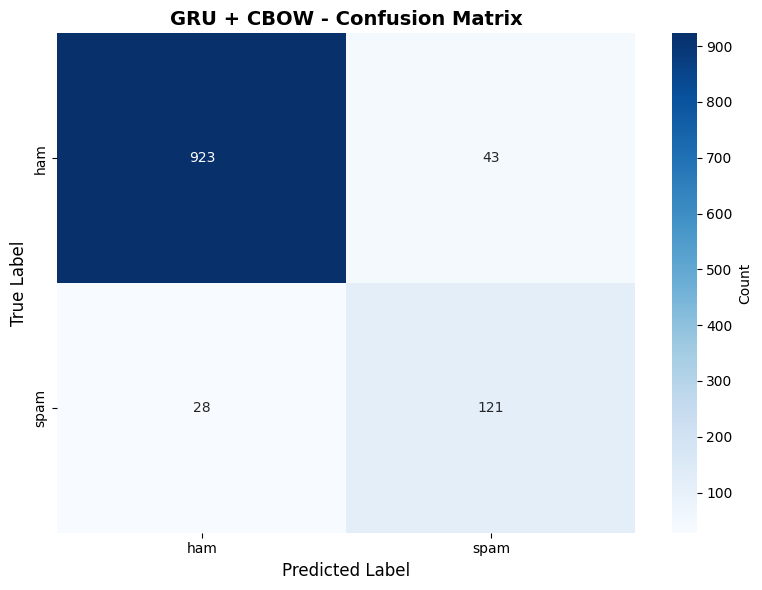

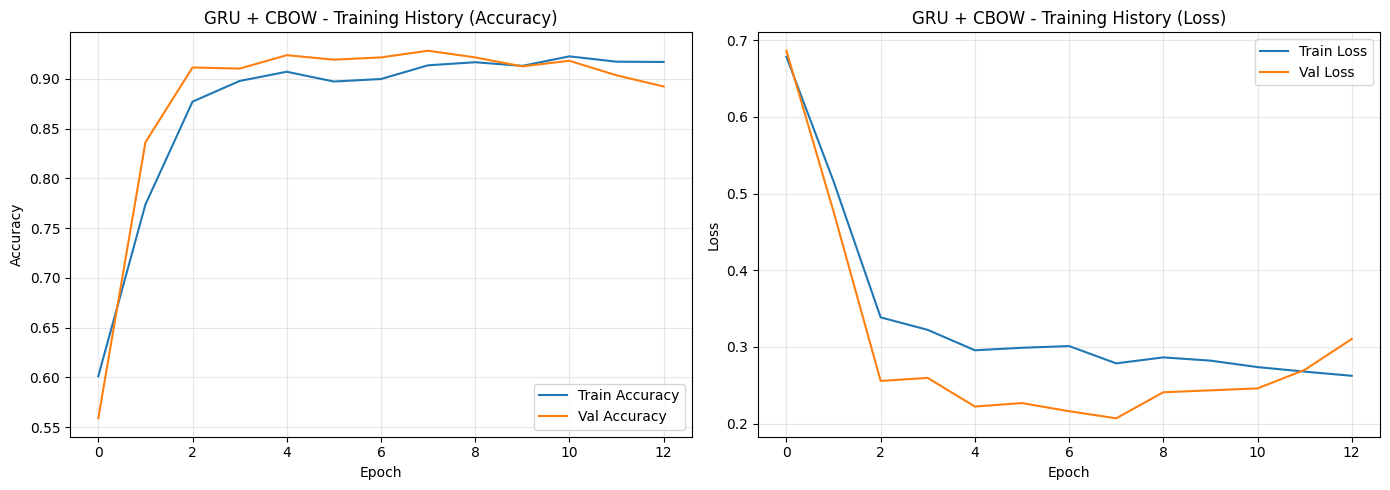

In [22]:
# Prepare CBOW embeddings (Word2Vec with sg=0)
print('Preparing CBOW embeddings...\n')

# Train CBOW Word2Vec model
cbow = Word2VecEmbedding(
    vector_size=100,
    window=5,
    min_count=2,
    sg=0,  # CBOW
    workers=4,
    epochs=10
)

print('Training CBOW model...')
cbow.train(X_train_tokens)
print(f'CBOW model trained with vocabulary size: {len(cbow.model.wv)}')

# Transform to document vectors
X_train_cbow = cbow.transform(X_train_tokens, method='mean')
X_test_cbow = cbow.transform(X_test_tokens, method='mean')

print(f'\nCBOW embeddings shape: {X_train_cbow.shape}')

# Build and train GRU with CBOW
set_seed(42)
tf.random.set_seed(42)

model_cbow = build_gru_word2vec_model(
    input_dim=X_train_cbow.shape[1],
    gru_units=64,
    dropout_rate=0.3,
    learning_rate=0.001
)

print('\n', model_cbow.summary())

# Train model with class weights
print('\n' + '='*60)
print('TRAINING GRU + CBOW')
print('='*60)
print(f"Using class weights: Ham={class_weight_dict[0]:.3f}, Spam={class_weight_dict[1]:.3f}")
print('='*60 + '\n')

start_time = time.time()

history_cbow = model_cbow.fit(
    X_train_cbow, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,  # ADD CLASS WEIGHTS
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

training_time_cbow = time.time() - start_time
print(f'\n✓ Training completed in {training_time_cbow:.2f}s')

# Make predictions
y_pred_cbow_prob = model_cbow.predict(X_test_cbow)
y_pred_cbow = (y_pred_cbow_prob > 0.5).astype(int).flatten()

# Evaluate
metrics_cbow = evaluator.evaluate(
    y_test, y_pred_cbow,
    model_name='GRU',
    embedding_name='CBOW',
    training_time=training_time_cbow
)

evaluator.print_metrics(metrics_cbow)

# Plot confusion matrix
fig_path = os.path.join(OUTPUT_DIR, 'figures', 'member4_cbow_cm.png') if not IS_KAGGLE else None
if not IS_KAGGLE:
    os.makedirs(os.path.join(OUTPUT_DIR, 'figures'), exist_ok=True)

evaluator.plot_confusion_matrix(
    y_test, y_pred_cbow,
    title='GRU + CBOW - Confusion Matrix',
    save_path=fig_path
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_cbow.history['accuracy'], label='Train Accuracy')
axes[0].plot(history_cbow.history['val_accuracy'], label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('GRU + CBOW - Training History (Accuracy)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history_cbow.history['loss'], label='Train Loss')
axes[1].plot(history_cbow.history['val_loss'], label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('GRU + CBOW - Training History (Loss)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()

if not IS_KAGGLE:
    os.makedirs(os.path.join(OUTPUT_DIR, 'figures'), exist_ok=True)
    plt.savefig(os.path.join(OUTPUT_DIR, 'figures', 'member4_cbow_history.png'), dpi=300, bbox_inches='tight')

plt.show()

## 7. Results Summary and Comparison

Results saved to /kaggle/working/tables/member4_results.csv

Results Summary:
  model  embedding  accuracy  precision    recall  f1_score  training_time
0   GRU     TF-IDF  0.980269   0.980063  0.980269  0.979916      11.524625
1   GRU  Skip-gram  0.958744   0.961599  0.958744  0.959725      26.129438
2   GRU       CBOW  0.936323   0.939454  0.936323  0.937600      17.270882


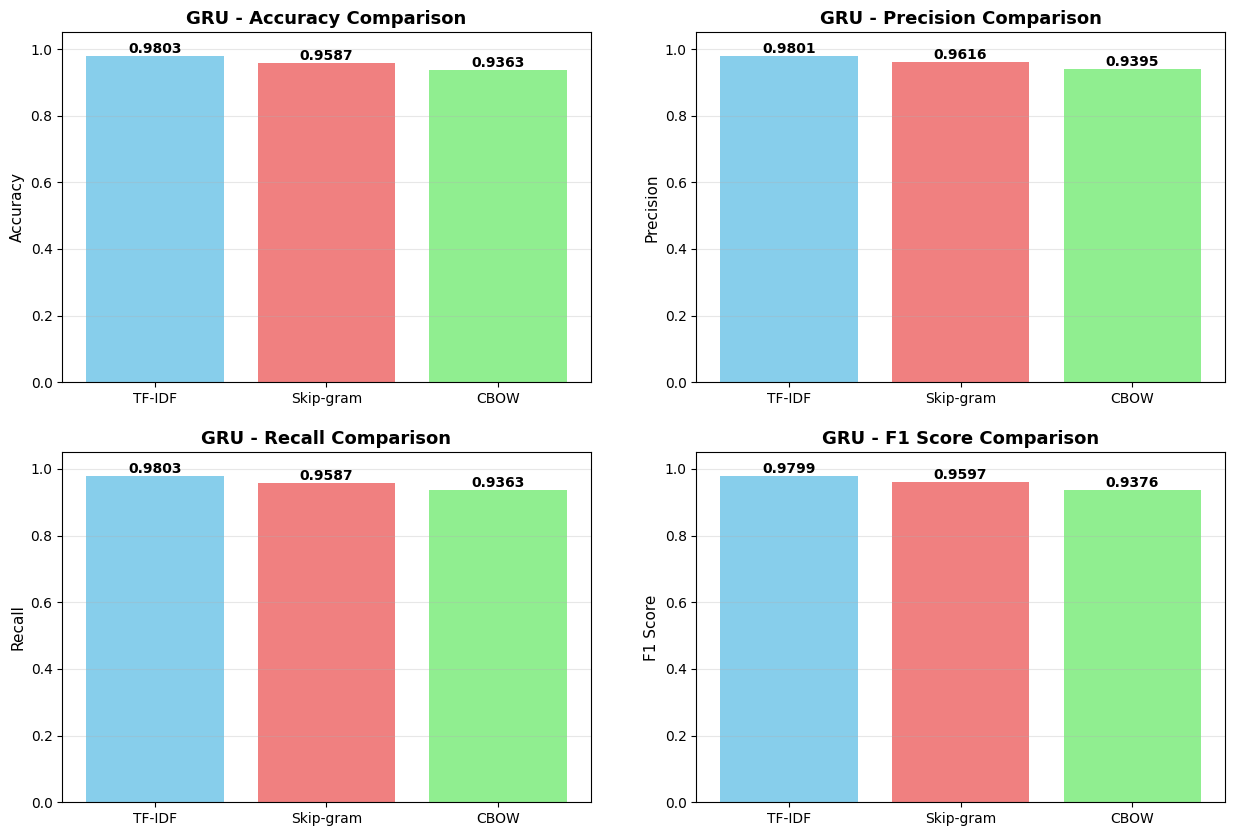

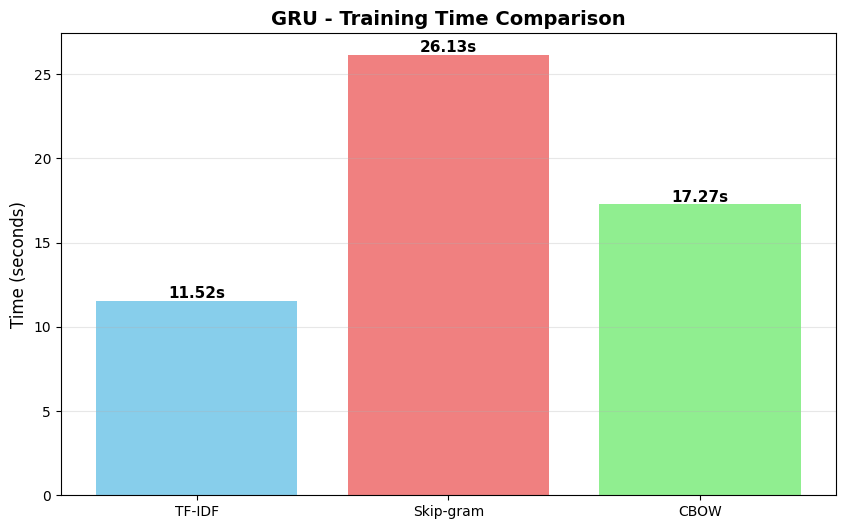

In [23]:
# Save all results to CSV
# Create directories (both for Kaggle and local)
os.makedirs(os.path.join(OUTPUT_DIR, 'tables'), exist_ok=True)
if not IS_KAGGLE:
    os.makedirs(os.path.join(OUTPUT_DIR, 'figures'), exist_ok=True)

results_path = os.path.join(OUTPUT_DIR, 'tables', 'member4_results.csv')
results_df = evaluator.save_results_table(filepath=results_path)

print('\nResults Summary:')
print('=' * 80)
print(results_df)

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

embeddings = results_df['embedding'].values
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 2
    col = idx % 2
    
    values = results_df[metric].values
    bars = axes[row, col].bar(embeddings, values, color=['skyblue', 'lightcoral', 'lightgreen'])
    
    axes[row, col].set_ylabel(metric.replace('_', ' ').title(), fontsize=11)
    axes[row, col].set_title(f'GRU - {metric.replace("_", " ").title()} Comparison', 
                             fontsize=13, fontweight='bold')
    axes[row, col].set_ylim([0, 1.05])
    axes[row, col].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.4f}',
                           ha='center', va='bottom', fontsize=10, fontweight='bold')
if not IS_KAGGLE:
    plt.savefig(os.path.join(OUTPUT_DIR, 'figures', 'member4_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Training time comparison
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(embeddings, results_df['training_time'].values, color=['skyblue', 'lightcoral', 'lightgreen'])
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('GRU - Training Time Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.2f}s',
           ha='center', va='bottom', fontsize=11, fontweight='bold')

if not IS_KAGGLE:
    plt.savefig(os.path.join(OUTPUT_DIR, 'figures', 'member4_training_time.png'), dpi=300, bbox_inches='tight')

plt.show()

## 9. Conclusions and Observations

**Key Findings:**

Based on experiments with GRU models across three embeddings (TF-IDF, Skip-gram, CBOW), we can compare performance and draw conclusions about which approach works best for SMS spam classification.